# Lab 8: Real-world data
Our goal today is to practice data interpretation and plotting with messy, real-world data.  

Our science question is: how does ocean temperature in the Pacific vary during ENSO events?

Below is only helper code.  You will receive a paper handout with some contour plots to process and questions to analyse.  You should set up your own Jupyter notebook and work through at your own pace.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

---
## Helper code: filling missing values

Below I show how to deal with a dataset with multiple data gaps.  There are many ways to deal with this in various Python packages; I am demonstrating some simple built-in functions in xarray called `interp` and `interpolate_na`.

Let's load in the data and inspect it.

In [2]:
ds = xr.open_dataset(r'/Users/lizz/Documents/GitHub/climdyn-labs/data/t_xyzt_mon_199901.cdf')

In [3]:
ds

<xarray.Dataset>
Dimensions:  (lon: 10, lat: 1, depth: 25, time: 1)
Coordinates:
  * lon      (lon) float32 147.0 156.0 165.0 180.0 ... 220.0 235.0 250.0 265.0
  * lat      (lat) float32 0.0
  * depth    (depth) float32 1.0 5.0 10.0 20.0 25.0 ... 250.0 300.0 400.0 500.0
  * time     (time) datetime64[ns] 1999-01-16T12:00:00
Data variables:
    T_20     (lon, lat, depth, time) float32 ...
    QT_5020  (lon, lat, depth, time) float32 ...
    ST_6020  (lon, lat, depth, time) float32 ...
Attributes:
    array:                        TAO/TRITON
    Data_Source:                  GTMBA Project Office/NOAA/PMEL
    Data_info:                    Contact Paul Freitag: 206-526-6727
    File_info:                    Contact Dai McClurg: Dai.C.McClurg@noaa.gov
    Request_for_acknowledgement:  If you use these data in publications or pr...
    missing_value:                1e+35
    _FillValue:                   1e+35

In [4]:
ds.T_20

<xarray.DataArray 'T_20' (lon: 10, lat: 1, depth: 25, time: 1)>
array([[[[29.968334],
         ...,
         [ 8.396998]]],


       ...,


       [[[23.82226 ],
         ...,
         [ 8.300323]]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 147.0 156.0 165.0 180.0 ... 220.0 235.0 250.0 265.0
  * lat      (lat) float32 0.0
  * depth    (depth) float32 1.0 5.0 10.0 20.0 25.0 ... 250.0 300.0 400.0 500.0
  * time     (time) datetime64[ns] 1999-01-16T12:00:00
Attributes:
    name:            T
    long_name:       TEMPERATURE (C)long_namet
    generic_name:    temp
    FORTRAN_format:  f10.2
    units:           C
    epic_code:       20

Our variable of interest, `T_20`, has several dimensions of length 1.  For example, it has a `lat` dimension which is always equal to 0 because it's averaged around the equator, and it has a `time` dimension that has only one value, because we downloaded a time slice.  We use `.squeeze()` to remove those dimensions and make this data easier to deal with.

In [5]:
t20 = ds.T_20.squeeze()

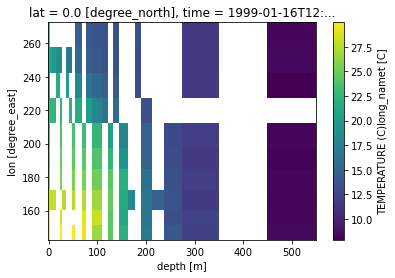

In [6]:
fig, ax = plt.subplots()
t20.plot(ax=ax)

This plot has longitude on the y-axis and temperature on the x-axis.  We can swap these by using `ax.plot(xdata, ydata)` as you've done before, or we can take the [*transpose*](https://en.wikipedia.org/wiki/Transpose) to swap the axes.  The command `.T` takes the transpose.  It works for xarray variables, Numpy arrays, etc.

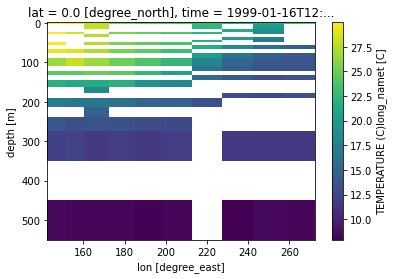

In [7]:
fig, ax = plt.subplots()
t20.T.plot(ax=ax) ## flip the x- and y-axes, for depth on y-axis
ax.invert_yaxis() ## flipping so y-axis increases downward, appropriate for ocean depth section

We can see that there are a lot of data gaps.  The same is true if we try a filled contour plot like we made last week:

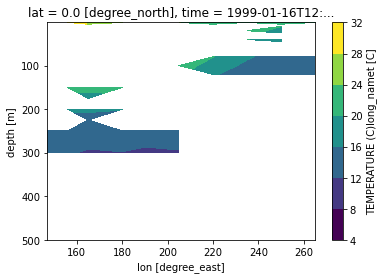

In [8]:
fig, ax = plt.subplots()
t20.T.plot.contourf(ax=ax)
ax.invert_yaxis()

Let's try a temperature profile.

[Text(0.5, 0, 'Temperature [deg. C]'), Text(0, 0.5, 'Depth [m]')]

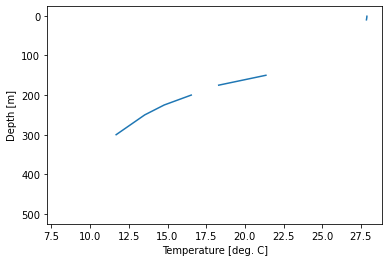

In [9]:
fig, ax = plt.subplots()
# t20.sel(lon=165.0).T.plot(ax=ax) ## .T doesn't work here, for reasons I do not know
ax.plot(t20.sel(lon=165.0), t20.depth.values) ## use good ol' ax.plot instead
ax.invert_yaxis() ## flipping so y-axis increases downward, appropriate for ocean depth section
ax.set(xlabel = 'Temperature [deg. C]', ylabel='Depth [m]')

Also a lot of gaps!  We need to fill these gaps to make profiles comparable to those we were making by hand from TAO/TRITON contour plots.  

Here I am first going to fill `NaN` ("not a number") values in the `t20` variable using `interpolate_na`.  Then, I am going to interpolate with `interp` to find the values along a regularly spaced grid of depth and longitude.

In [10]:
t20_filled = t20.interpolate_na(dim='depth') ## filling NaNs
    
t20_gridded = t20_filled.interp(depth=t20.depth.values, lon=t20.lon.values) ## interpolating the filled data

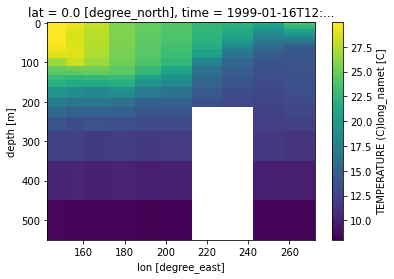

In [11]:
fig, ax = plt.subplots()
t20_gridded.T.plot(ax=ax)
ax.invert_yaxis()

The grid is much more complete now.  Notice that it still ignored a large area of missing data, which is probably for the best.  We don't want a false sense of certainty in an area where we actually don't have any observations.

[Text(0.5, 0, 'Temperature [deg. C]'), Text(0, 0.5, 'Depth [m]')]

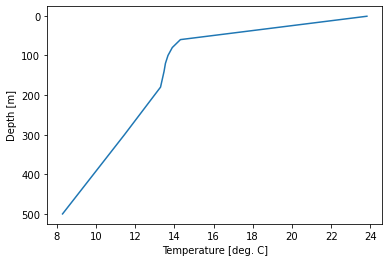

In [12]:
fig, ax = plt.subplots()
ax.plot(t20_gridded.sel(lon=265), t20_gridded.depth.values) ## plotting from t20_gridded instead of t20
ax.invert_yaxis()
ax.set(xlabel = 'Temperature [deg. C]', ylabel='Depth [m]')

Temperature profile is also continuous now, and we can make a much nicer filled contour plot.

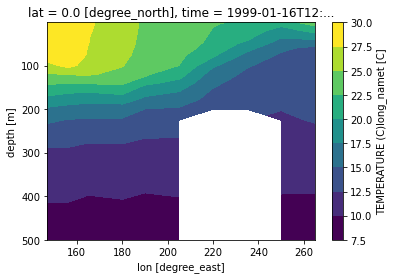

In [13]:
fig, ax = plt.subplots()
t20_gridded.T.plot.contourf(ax=ax, levels=10) ## remember you can modify levels, colorbars, etc.
ax.invert_yaxis()

In [14]:
## it's possible to fill in the lon dimension as well, but could be questionable
t20_filled_lon = t20_filled.interpolate_na(dim='lon')
    
t20_gridded_full = t20_filled_lon.interp(depth=t20.depth.values, lon=t20.lon.values)

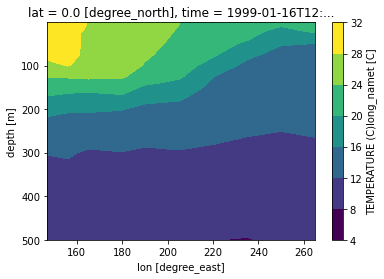

In [15]:
fig, ax = plt.subplots()
t20_gridded_full.T.plot.contourf(ax=ax)
ax.invert_yaxis()

---
## Multiple-panel plots
Finally, to help you compare profiles, I show how to make side-by-side plots with `subplots`.

We've been using `plt.subplots()` to give us access to axes we cou;d control for better plotting.  The same setup actually allows us to make multi-panel figures with ease.  The primary format is:
```
fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True)
axs[which_row,which_column].plot(xdata, ydata)
```
where nrows is the number of rows of panels, ncols is the number of columns, and sharex/sharey define whether the panels should have the same axes limits and scales.  `axs` is now an array of axes rather than the single named `ax` we have used before.  We can access it by naming the axes themselves, or by indexing `axs[which_row,which_column]` as shown above.

Let's apply this to two panels of profiles from our data:

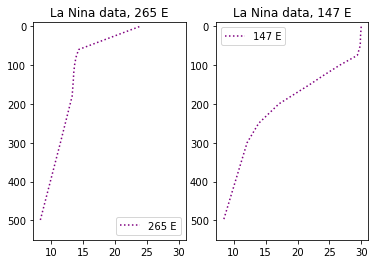

In [16]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(t20_gridded.sel(lon=265), t20_gridded.depth.values, color='purple', ls=':', label='265 E')
ax1.legend(loc='best')
ax1.set(ylim=(550, -10), title='La Nina data, 265 E')

ax2.plot(t20_gridded.sel(lon=147), t20_gridded.depth.values, color='purple', ls=':', label='147 E')
ax2.legend(loc='best')
ax2.set(ylim=(550, -10), title='La Nina data, 147 E');

## Endnotes
- The [xarray user guide on interpolation](https://docs.xarray.dev/en/latest/user-guide/interpolation.html) describes `interp` and `interpolate_na`...plus several other options for various use cases.
- Scipy is also commonly used for interpolation.  Their general landing page is [here](https://docs.scipy.org/doc/scipy/reference/interpolate.html).  I would probably choose `griddata` for an application like this -- documented [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata).
- This notebook last edited by Lizz Ultee, 9 Apr 2024

---
## Bonus material: time series and fill values
Sometimes you get datasets that have data gaps, but the gaps have a *fill value*.  If you are lucky, this fill value will be declared somewhere in the dataset header.  If you are unlucky, you will find out when you try to compute some statistic and you get a wildly incorrect value.  This is why we do preliminary checks of the mean, min, max, etc. :)

I was interested in the [Oceanic Niño Index](https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-nino-index), which is how we monitor ENSO conditions. I wanted to see if I could compute the ONI myself from TAO/TRITON data.  Here is what I did.

First, on the TAO/TRITON page, I selected "Time Series" and dragged a box around the sites in the central Pacific that go into the ONI.  I asked for the SST data to be delivered in NetCDF format.

In [17]:
ds2 = xr.open_dataset(r'/Users/lizz/Downloads/sst_xyt_mon-20240408.cdf')  ## Loading in the data
ds2

<xarray.Dataset>
Dimensions:  (time: 485, depth: 1, lat: 8, lon: 4)
Coordinates:
  * time     (time) datetime64[ns] 1983-11-16T12:00:00 ... 2024-03-16T12:00:00
  * depth    (depth) float32 0.0
  * lat      (lat) float32 -8.0 -5.0 -2.0 0.0 2.0 5.0 8.0 9.0
  * lon      (lon) float32 190.0 205.0 220.0 235.0
Data variables:
    T_20     (time, depth, lat, lon) float32 ...
    QT_5020  (time, depth, lat, lon) float32 ...
    ST_6020  (time, depth, lat, lon) float32 ...
Attributes:
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    array:                        TAO/TRITON
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    Request_for_acknowledgement:  If you use these data in publications or pr...
    CREATION_DATE:                08:31  8-APR-2024

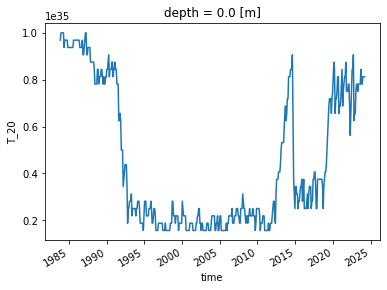

In [18]:
ds2.T_20.mean(dim=['lat', 'lon']).plot()

Hah, clearly this has a fill value of 1e35 that we need to mask out.  If I had been paying attention to the Attributes of the xarray dataset, I would've seen "missing_value: 1e+35".

I can mask (as in Lab 6) to take only the values that are *not* the fill value.  I took a whole lot of trial and error to do this.

In [19]:
sst_series_masked = ds2.T_20.where(ds.T_20 != 1e35) ## this is the right idea, but it's not gonna work.  Do I know why?  I do not.
sst_series_masked.plot()

IndexError: index -1 is out of bounds for axis 0 with size 0

It's complaining that there are no values left, even though I can see non-fill values when I inspect the data.  I can see this when I try to take the mean:

In [20]:
sst_series_masked.mean(dim=['lat', 'lon'])

<xarray.DataArray 'T_20' (time: 1, depth: 0)>
array([], shape=(1, 0), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-16T12:00:00
  * depth    (depth) float64

The mean is empty.  For some reason, assigning the masked variable to a new named variable is not working.  But I still need to take the mean over all locations to compute the Oceanic Niño Index.  What to do?

Several Python packages have the ability to deal with NaN values (like we did above).  My first thought was to use numpy.nanmean, which takes a mean while ignoring all NaN values.  But I thought there was probably an xarray equivalent, and I was right.  We can use the usual xarray `.mean()` and add the optional argument `skipna=True`.

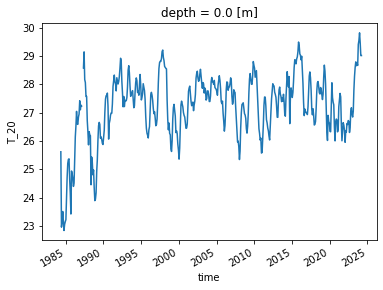

In [21]:
# ds2.T_20.squeeze().where(ds2.T_20 != 1e35).squeeze().mean(dim=['lat','lon'], skipna=True).plot() 
## I tried removing single-value dimensions above, but it doesn't actually make a difference
ds2.T_20.where(ds2.T_20 != 1e35).mean(dim=['lat','lon'], skipna=True).plot()

This looks better.  I'm going to assign this to a named variable.  

Next, I need to take a 3-month [rolling mean](https://en.wikipedia.org/wiki/Moving_average), and I need to subtract the long-term average.  Current best practice is to update the base long-term average every 5 years (see [NOAA description](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_change.shtml)).  I am going to achieve something similar by subtracting a 30-year rolling average (360 time periods i.e. months).  I cheat a little bit by allowing the mean to be computed in shorter windows at the beginning and end of the series as long as there are half as many data points (min_periods=180).  Otherwise a 30-year mean would strongly reduce the length of the period I could study.  Note that this does make values at the start and end of the period a bit more variable / less reliable.

In [22]:
avg_SST = ds2.T_20.squeeze().where(ds2.T_20 != 1e35).squeeze().mean(dim=['lat','lon'], skipna=True)
ONI = avg_SST.rolling(time=3, center=True).mean() - avg_SST.rolling(time=360, center=True, min_periods=180).mean() 
## subtract rolling mean over 30 years

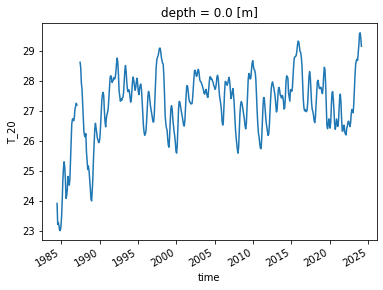

In [23]:
avg_SST.rolling(time=3, center=True).mean().plot() ## show first the 3-month rolling mean of SST

[(-2.0, 2.0),
 Text(0.5, 0, 'Years'),
 Text(0, 0.5, 'Oceanic Niño Index [$^\\circ$C]')]

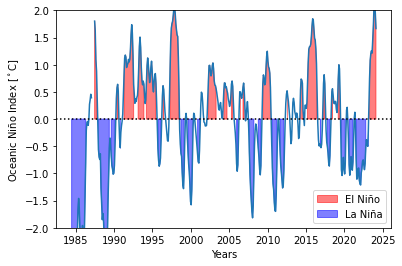

In [24]:
fig, ax = plt.subplots()
ax.plot(ONI.time.values, ONI.values)
ax.fill_between(ONI.time.values, np.zeros(len(ONI.values)), ONI.values, where=ONI.values>0.5, 
                color='red', alpha=0.5, label='El Niño')
ax.fill_between(ONI.time.values, np.zeros(len(ONI.values)), ONI.values, where=ONI.values<-0.5, 
                color='blue', alpha=0.5, label='La Niña')
ax.axhline(0, ls=':', color='k')
ax.legend(loc='best')
ax.set(ylim=(-2,2),
      xlabel='Years',
      ylabel=r'Oceanic Niño Index [$^\circ$C]')

I used [`ax.fill_between`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.fill_between.html) to shade positive (El Niño) conditions where the ONI is more than 0.5$^\circ$C above the average, and negative (La Niña) conditions where the ONI is more than 0.5$^\circ$C below average.  Other conditions are considered ENSO-neutral.

Can you identify the years you studied on this plot?